# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement different image models on MNIST using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras).

## Learning Objectives
1. Understand how to build a Dense Neural Network (DNN) for image classification
2. Understand how to use dropout (DNN) for image classification
3. Understand how to use Convolutional Neural Networks (CNN)
4. Know how to deploy and use an image classifcation model using Google Cloud's [AI Platforms](https://cloud.google.com/ai-platform/)

First things first. Configure the parameters below to match your own Google Cloud project details.

In [1]:
from datetime import datetime
import os

PROJECT = "your-project-id-here"  # REPLACE WITH YOUR PROJECT ID
BUCKET = "your-bucket-id-here"  # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1"  # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["IMAGE_URI"] = os.path.join("gcr.io", PROJECT, "mnist_trainer")

## Building a dynamic model

In the previous notebook, <a href="mnist_linear.ipynb">mnist_linear.ipynb</a>, we ran our code directly from the notebook. In order to run it on the AI Platform, it needs to be packaged as a python module.

The boilerplate structure for this module has already been set up in the folder `mnist_models`. The module lives in the sub-folder, `trainer`, and is designated as a python package with the empty `__init__.py` (`mnist_models/trainer/__init__.py`) file. It still needs the model and a trainer to run it, so let's make them.

Let's start with the trainer file first. This file parses command line arguments to feed into model.

In [2]:
%%writefile mnist_trainer/trainer/task.py
import argparse
import json
import os
import sys

from . import model


def _parse_arguments(argv):
    """Parses command-line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--model_type',
        help='Which model type to use',
        type=str, default='linear')
    parser.add_argument(
        '--epochs',
        help='The number of epochs to train',
        type=int, default=10)
    parser.add_argument(
        '--steps_per_epoch',
        help='The number of steps per epoch to train',
        type=int, default=100)
    parser.add_argument(
        '--job-dir',
        help='Directory where to save the given model',
        type=str, default='mnist_models/')
    return parser.parse_known_args(argv)


def main():
    """Parses command line arguments and kicks off model training."""
    args = _parse_arguments(sys.argv[1:])[0]

    # Configure path for hyperparameter tuning.
    trial_id = json.loads(
        os.environ.get('TF_CONFIG', '{}')).get('task', {}).get('trial', '')
    output_path = args.job_dir if not trial_id else args.job_dir + '/'

    model_layers = model.get_layers(args.model_type)
    image_model = model.build_model(model_layers, args.job_dir)
    model_history = model.train_and_evaluate(
        image_model, args.epochs, args.steps_per_epoch, args.job_dir)


if __name__ == '__main__':
    main()


Overwriting mnist_trainer/trainer/task.py


Next, let's group non-model functions into a util file to keep the model file simple. We'll copy over the `scale` and `load_dataset` functions from the previous lab.

In [3]:
%%writefile mnist_trainer/trainer/util.py
import tensorflow as tf


def scale(image, label):
    """Scales images from a 0-255 int range to a 0-1 float range"""
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.expand_dims(image, -1)
    return image, label


def load_dataset(
        data, training=True, buffer_size=5000, batch_size=100, nclassses=10):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = data
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, nclassses)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(batch_size)
    if training:
        dataset = dataset.shuffle(buffer_size).repeat()
    return dataset


Overwriting mnist_trainer/trainer/util.py


Finally, let's code the models! The [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras) accepts an array of [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) into a [model object](https://www.tensorflow.org/api_docs/python/tf/keras/Model), so we can create a dictionary of layers based on the different model types we want to use. The below file has two functions: `get_layers` and `create_and_train_model`. We will build the structure of our model in `get_layers`. Last but not least, we'll copy over the training code from the previous lab into `train_and_evaluate`.

**TODO 1**: Define the Keras layers for a DNN model   
**TODO 2**: Define the Keras layers for a dropout model  
**TODO 3**: Define the Keras layers for a CNN model  

Hint: These models progressively build on each other. Look at the imported `tensorflow.keras.layers` modules and the default values for the variables defined in `get_layers` for guidance.

In [4]:
%%writefile mnist_trainer/trainer/model.py
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)

from . import util


# Image Variables
WIDTH = 28
HEIGHT = 28


def get_layers(
        model_type,
        nclasses=10,
        hidden_layer_1_neurons=400,
        hidden_layer_2_neurons=100,
        dropout_rate=0.25,
        num_filters_1=64,
        kernel_size_1=3,
        pooling_size_1=2,
        num_filters_2=32,
        kernel_size_2=3,
        pooling_size_2=2):
    """Constructs layers for a keras model based on a dict of model types."""
    model_layers = {
        'linear': [
            Flatten(),
            Dense(nclasses),
            Softmax()
        ],
        'dnn': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dense(nclasses),
            Softmax()
        ],
        'dnn_dropout': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ],
        'cnn': [
            Conv2D(num_filters_1, kernel_size=kernel_size_1,
                   activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
            MaxPooling2D(pooling_size_1),
            Conv2D(num_filters_2, kernel_size=kernel_size_2,
                   activation='relu'),
            MaxPooling2D(pooling_size_2),
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ]
    }
    return model_layers[model_type]


def build_model(layers, output_dir):
    """Compiles keras model for image classification."""
    model = Sequential(layers)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def train_and_evaluate(model, num_epochs, steps_per_epoch, output_dir):
    """Compiles keras model and loads data into it for training."""
    mnist = tf.keras.datasets.mnist.load_data()
    train_data = util.load_dataset(mnist)
    validation_data = util.load_dataset(mnist, training=False)

    callbacks = []
    if output_dir:
        tensorboard_callback = TensorBoard(log_dir=output_dir)
        callbacks = [tensorboard_callback]

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=2,
        callbacks=callbacks)

    if output_dir:
        export_path = os.path.join(output_dir, 'keras_export')
        model.save(export_path, save_format='tf')

    return history


Overwriting mnist_trainer/trainer/model.py


## Local Training

With everything set up, let's run locally to test the code. Some of the previous tests have been copied over into a testing script `mnist_models/trainer/test.py` to make sure the model still passes our previous checks. On `line 34`, you can specify which model types you would like to check. `line 37` and `line 38` has the number of epochs and steps per epoch respectively.

In [5]:
!python3 -m mnist_trainer.trainer.test

2019-10-17 23:05:11.809697: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-10-17 23:05:11.832086: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-10-17 23:05:11.832379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a62f084ed0 executing computations on platform Host. Devices:
2019-10-17 23:05:11.832419: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
.2019-10-17 23:05:22.252714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:111] Filling up shuffle buffer (this may take a while): 1189 of 5000
2019-10-17 23:05:27.251643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:162] Shuffle buffer filled.
.
*** Building model for linear ***

Epoch 1/10
2019-10-17 23:05:37.671696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:111] Filling up shuffle buffer (thi

Now that we know that our models are working as expected, let's run it on the [Google Cloud AI Platform](https://cloud.google.com/ml-engine/docs/). We can run it as a python module locally first using the command line.

The below cell transfers some of our variables to the command line as well as create a job directory including a timestamp. This is where our model and tensorboard data will be stored.

In [6]:
current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn'

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "mnist_trainer/models/{}_{}/".format(
    model_type, current_time)

The cell below runs the local version of the code. The epochs and steps_per_epoch flag can be changed to run for longer or shorther, as defined in our `mnist_models/trainer/task.py` file.

In [7]:
%%bash
mkdir $JOB_DIR
python3 -m mnist_trainer.trainer.task \
    --job-dir=$JOB_DIR \
    --epochs=5 \
    --steps_per_epoch=50 \
    --model_type=$MODEL_TYPE

Epoch 1/5
50/50 - 24s - loss: 1.0369 - accuracy: 0.6758 - val_loss: 0.3286 - val_accuracy: 0.9000
Epoch 2/5
50/50 - 5s - loss: 0.2849 - accuracy: 0.9164 - val_loss: 0.1770 - val_accuracy: 0.9457
Epoch 3/5
50/50 - 5s - loss: 0.1949 - accuracy: 0.9424 - val_loss: 0.1106 - val_accuracy: 0.9655
Epoch 4/5
50/50 - 5s - loss: 0.1453 - accuracy: 0.9574 - val_loss: 0.0896 - val_accuracy: 0.9723
Epoch 5/5
50/50 - 5s - loss: 0.1516 - accuracy: 0.9526 - val_loss: 0.0988 - val_accuracy: 0.9698


2019-10-17 23:09:58.662758: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-10-17 23:09:58.667843: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-10-17 23:09:58.668114: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b7a51cac40 executing computations on platform Host. Devices:
2019-10-17 23:09:58.668141: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-10-17 23:10:09.231986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:111] Filling up shuffle buffer (this may take a while): 1143 of 5000
2019-10-17 23:10:17.342438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:162] Shuffle buffer filled.
W1017 23:10:17.412490 139681778824960 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch

Let's check out how the model did in tensorboard and confirm that it's good to go before kicking it off to train on the cloud. If running on a Deep Learning VM, open the folder corresponding to the `--job-dir` above. Then, go to File > New Launcher. Click on Tensorboard under "Other".

If runnining locally, the following command can be run in a terminal:

`tensorboard --logdir=<path-to-data-directory>`

## Training on the cloud

Since we're using an unreleased version of TensorFlow on AI Platform, we can instead use a [Deep Learning Container](https://cloud.google.com/ai-platform/deep-learning-containers/docs/overview) in order to take advantage of libraries and applications not normally packaged with AI Platform. Below is a simple [Dockerlife](https://docs.docker.com/engine/reference/builder/) which copies our code to be used in a TF2 environment.

In [8]:
%%writefile mnist_trainer/Dockerfile
FROM gcr.io/deeplearning-platform-release/tf2-cpu
COPY trainer /trainer
ENTRYPOINT ["python3", "-m", "trainer.task"]

Overwriting mnist_trainer/Dockerfile


The below command builds the image and ships it off to Google Cloud so it can be used for AI Platform. When built, it will show up [here](https://pantheon.corp.google.com/gcr) with the name `mnist_trainer`. ([Click here](https://console.cloud.google.com/cloud-build) to enable Cloud Build)

In [10]:
!gcloud builds submit --tag $IMAGE_URI mnist_trainer/

Creating temporary tarball archive of 44 file(s) totalling 18.8 MiB before compression.
Uploading tarball of [mnist_trainer/] to [gs://ddetering-experimental_cloudbuild/source/1571354526.6-aca8ef4db5a64540859e25e18a88a0fb.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/ddetering-experimental/builds/cd0f5b7c-1cbd-4ad0-bdb8-ae26522ef8e8].
Logs are available at [https://console.cloud.google.com/gcr/builds/cd0f5b7c-1cbd-4ad0-bdb8-ae26522ef8e8?project=894743430090].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "cd0f5b7c-1cbd-4ad0-bdb8-ae26522ef8e8"

FETCHSOURCE
Fetching storage object: gs://ddetering-experimental_cloudbuild/source/1571354526.6-aca8ef4db5a64540859e25e18a88a0fb.tgz#1571354528569451
Copying gs://ddetering-experimental_cloudbuild/source/1571354526.6-aca8ef4db5a64540859e25e18a88a0fb.tgz#1571354528569451...
- [1 files][ 16.5 MiB/ 16.5 MiB]                                                
Operation completed over 1 obje

Finally, we can kickoff the [AI Platform training job](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training). We can pass in our docker image using the `master-image-uri` flag.

In [11]:
current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn'

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "gs://{}/mnist_{}_{}/".format(
    BUCKET, model_type, current_time)
os.environ["JOB_NAME"] = "mnist_{}_{}".format(
    model_type, current_time)

In [12]:
%%bash
echo $JOB_DIR $REGION $JOB_NAME
gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket=gs://$BUCKET \
    --region=$REGION \
    --master-image-uri=$IMAGE_URI \
    --scale-tier=BASIC_GPU \
    --job-dir=$JOB_DIR \
    -- \
    --model_type=$MODEL_TYPE

gs://ddetering-experimental/mnist_cnn_191017_233152/ us-central1 mnist_cnn_191017_233152
jobId: mnist_cnn_191017_233152
state: QUEUED


Job [mnist_cnn_191017_233152] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mnist_cnn_191017_233152

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mnist_cnn_191017_233152


Can't wait to see the results? Run the code below and copy the output into the [Google Cloud Shell](https://console.cloud.google.com/home/dashboard?cloudshell=true) to follow along with TensorBoard. Look at the web preview on port 6006.

In [13]:
!echo "tensorboard --logdir $JOB_DIR"

tensorboard --logdir gs://ddetering-experimental/mnist_cnn_191017_233152/


## Deploying and predicting with model

Once you have a model you're proud of, let's deploy it! All we need to do is give AI Platform the location of the model. Below uses the keras export path of the previous job, but `${JOB_DIR}keras_export/` can always be changed to a different path.

Even though we're using a 1.14 runtime, it's compatable with TF2 exported models. Phew!

Uncomment the delete commands below if you are getting an "already exists error" and want to deploy a new model.

In [17]:
%%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=${JOB_DIR}keras_export/
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#yes | gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#yes | gcloud ai-platform models delete ${MODEL_NAME}
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} \
    --model ${MODEL_NAME} \
    --origin ${MODEL_LOCATION} \
    --framework tensorflow \
    --runtime-version=1.14

Deleting and deploying mnist cnn from gs://ddetering-experimental/mnist_cnn_191017_233152/keras_export/ ... this will take a few minutes


Created ml engine model [projects/ddetering-experimental/models/mnist].
Creating version (this might take a few minutes)......
................................................................................................................................................................................................................................................................................................................................................................done.


To predict with the model, let's take one of the example images.

**TODO 4**: Write a `.json` file with image data to send to an AI Platform deployed model

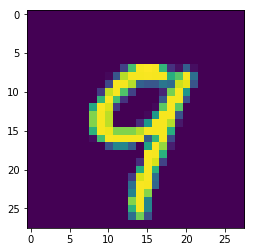

In [18]:
import json, codecs
import tensorflow as tf
import matplotlib.pyplot as plt
from mnist_trainer.trainer import util

HEIGHT = 28
WIDTH = 28
IMGNO = 12

mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
test_image = x_test[IMGNO]

jsondata = test_image.reshape(HEIGHT, WIDTH, 1).tolist()
json.dump(jsondata, codecs.open("test.json", "w", encoding = "utf-8"))
plt.imshow(test_image.reshape(HEIGHT, WIDTH));

Finally, we can send it to the prediction service. The output will have a 1 in the index of the correspoinding digit it is predicting. Congrats! You've completed the lab!

In [19]:
%%bash
gcloud ai-platform predict \
    --model=mnist \
    --version=${MODEL_TYPE} \
    --json-instances=./test.json

SOFTMAX_3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.